[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# YOLOv5 Instance Segmentation Tutorial

YOLOv5 is a popular version of the YOLO (You Only Look Once) object detection and image segmentation model, released on November 22, 2022 by Ultralytics. The YOLOv5 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

This notebook covers:

*   Inference with out-of-the-box YOLOv5 instance segmentation on COCO-128 Segmentatation
*  [Training YOLOv5 instance segmentation](https://blog.roboflow.com//train-yolov5-instance-segmentation-custom-dataset) on custom data

*Looking for custom data? Explore over 66M community datasets on [Roboflow Universe](https://universe.roboflow.com).*

This notebook was created with Google Colab. [Click here](https://colab.research.google.com/drive/1JTz7kpmHsg-5qwVz2d2IH3AaenI1tv0N?usp=sharing) to run it.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Feb 10 06:37:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Install YOLOv5

In [2]:
# save the working directory path for later use
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
# clone YOLOv5 repository
%cd /content
!git clone https://github.com/ultralytics/yolov5

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17269 (from 2)
Receiving objects: 100% (17270/17270), 16.12 MiB | 15.29 MiB/s, done.
Resolving deltas: 100% (11858/11858), done.


In [4]:
# install dependencies as necessary
%cd /content/yolov5
!pip install -r requirements.txt
!pip uninstall wandb -qy  # deprecated dependency
import torch

from IPython.display import Image, clear_output  # to display images

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.7/914.7 kB 57.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.

# Inference on test image

To demonstrate YOLOv5 instance segmentation, we'll leverage an already trained model. In this case, we'll download the COCO-128 trained models pretrained on COCO-128 using YOLOv5 Utils.

If you'd like to skip to custom trainining, jump to section 3 below.

/content/yolov5
segment/predict: weights=['yolov5s-seg.pt'], source=data/images/bus.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=test-inference, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5s-seg summary: 224 layers, 7611485 parameters, 0 gradients, 26.4 GFLOPs
image 1/1 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 40.0ms
Speed: 0.5ms pre-process, 40.0ms inference, 523.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/predict-seg/test-inference2


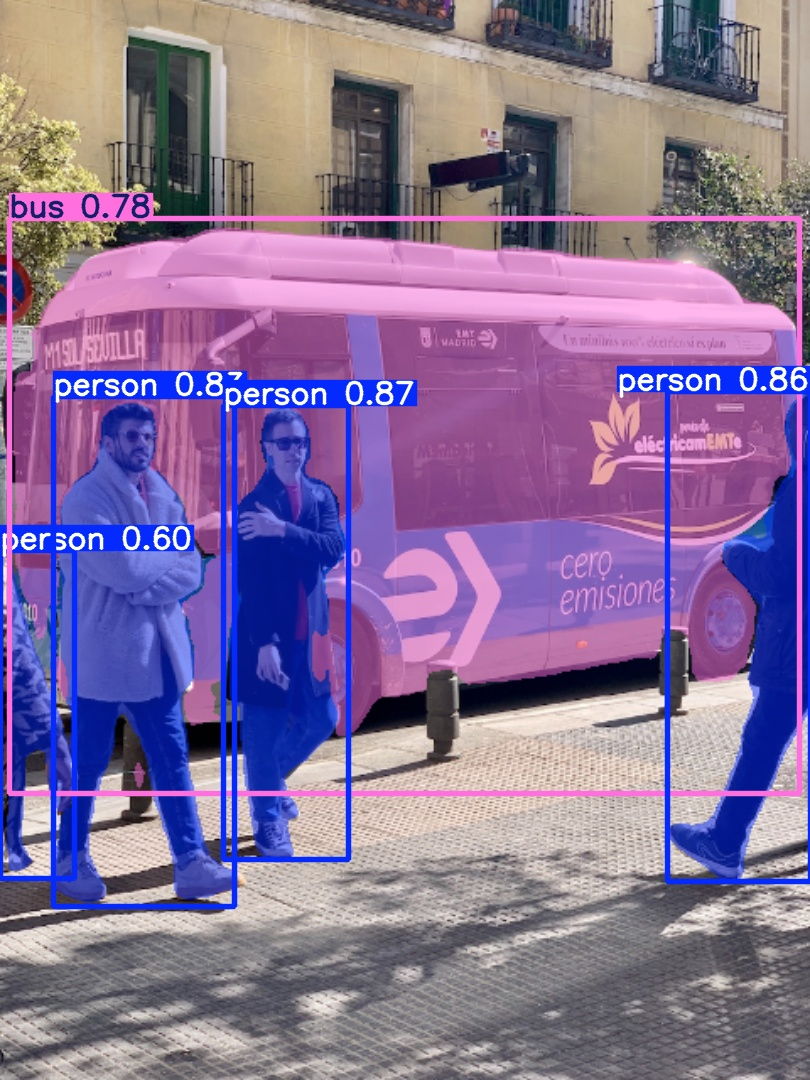

In [ ]:
# infer using segment/predict.py

%cd {HOME}/yolov5
!python segment/predict.py --weights yolov5s-seg.pt --source data/images/bus.jpg --name test-inference
Image(filename=f"{HOME}/yolov5/runs/predict-seg/test-inference/bus.jpg", width=600)

# 2. Infer on COCO image

In [ ]:
PATH_TO_IMAGE = f"{HOME}/zebra.jpg"
!curl https://i.imgur.com/EbOBS5l.jpg -o {PATH_TO_IMAGE}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  101k  100  101k    0     0   584k      0 --:--:-- --:--:-- --:--:--  585k


/content/yolov5
segment/predict: weights=['yolov5s-seg.pt'], source=/content/zebra.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=coco, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5s-seg summary: 224 layers, 7611485 parameters, 0 gradients, 26.4 GFLOPs
image 1/1 /content/zebra.jpg: 448x640 1 zebra, 40.5ms
Speed: 0.5ms pre-process, 40.5ms inference, 517.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/predict-seg/coco


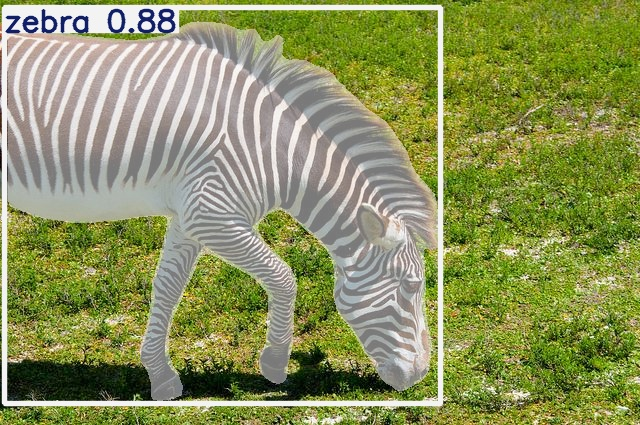

In [ ]:
#Infer using segment/predict.py
%cd {HOME}/yolov5
!python segment/predict.py --weights yolov5s-seg.pt --source {PATH_TO_IMAGE} --name coco
Image(filename=f"{HOME}/yolov5/runs/predict-seg/coco/zebra.jpg", width=600)

## Roboflow Universe

Need data for your project? Before spending time on annotating, check out Roboflow Universe, a repository of more than 200,000 open-source datasets that you can use in your projects. You'll find datasets containing everything from annotated cracks in concrete to plant images with disease annotations.


[![Roboflow Universe](https://media.roboflow.com/notebooks/template/uni-banner-frame.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672878480290)](https://universe.roboflow.com/)

## Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Instance Segmentation.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/creating-project.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929799852"
  >
</div>

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/uploading-images.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929808290"
  >
</div>

### Step 3: Labeling

If you only have images, you can label them in [Roboflow Annotate](https://docs.roboflow.com/annotate).

<div align="center">
  <img
    width="640"
    src="https://user-images.githubusercontent.com/26109316/210901980-04861efd-dfc0-4a01-9373-13a36b5e1df4.gif"
  >
</div>

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/generate-new-version.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1673003597834"
  >
</div>

### Step 5: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLO v5 PyTorch` dataset format.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/export.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672943313709"
  >
</div>


## Step 6: Download a Dataset

Run the code below to authenticate with Roboflow and download the dataset. Follow the link to generate an authentication token.

Alternatively, provide an API key like so: `rf = Roboflow(api_key=...)`

> 🟢 **Tip:** The examples below work even if you use our non-custom dataset. However, you won't be able to deploy the model to Roboflow. To do that, create a custom dataset as described above or fork (copy) one into your [workspace](https://app.roboflow.com/) from [Universe](https://universe.roboflow.com/).

In [6]:
# %cd /content/yolov5
%cd /content/yolov5
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CnNRm7VKq4uI0XwZEnVH")
project = rf.workspace("railwayinstancesegmentation").project("custom-workflow-instance-segmentation-p0cfg")
version = project.version(1)
dataset = version.download("yolov5")

/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


### Train On Custom Data 🎉
Here, we use the `dataset.location` attribute to pass our dataset to the `--data` parameter.

Note: we're training for 30 epochs here. We're also starting training from the pretrained weights. Larger datasets will likely benefit from longer training. This can often be around 1000-3000.

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **name:** result names
- **cache:** cache images for faster training

In [7]:
%cd {HOME}/yolov5
!python segment/train.py \
  --img 320 \
  --batch 128 \
  --epochs 30 \
  --data {dataset.location}/data.yaml \
  --weights yolov5s-seg.pt \
  --name custom-dataset \
  --cache

/content/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
2025-02-10 06:44:06.008393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739169846.263256    2619 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739169846.329203    2619 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
segment/train: weights=yolov5s-seg.pt, cfg=, data=/content/yolov5/Custom-Workflow-Instance-Segmentation-1/data

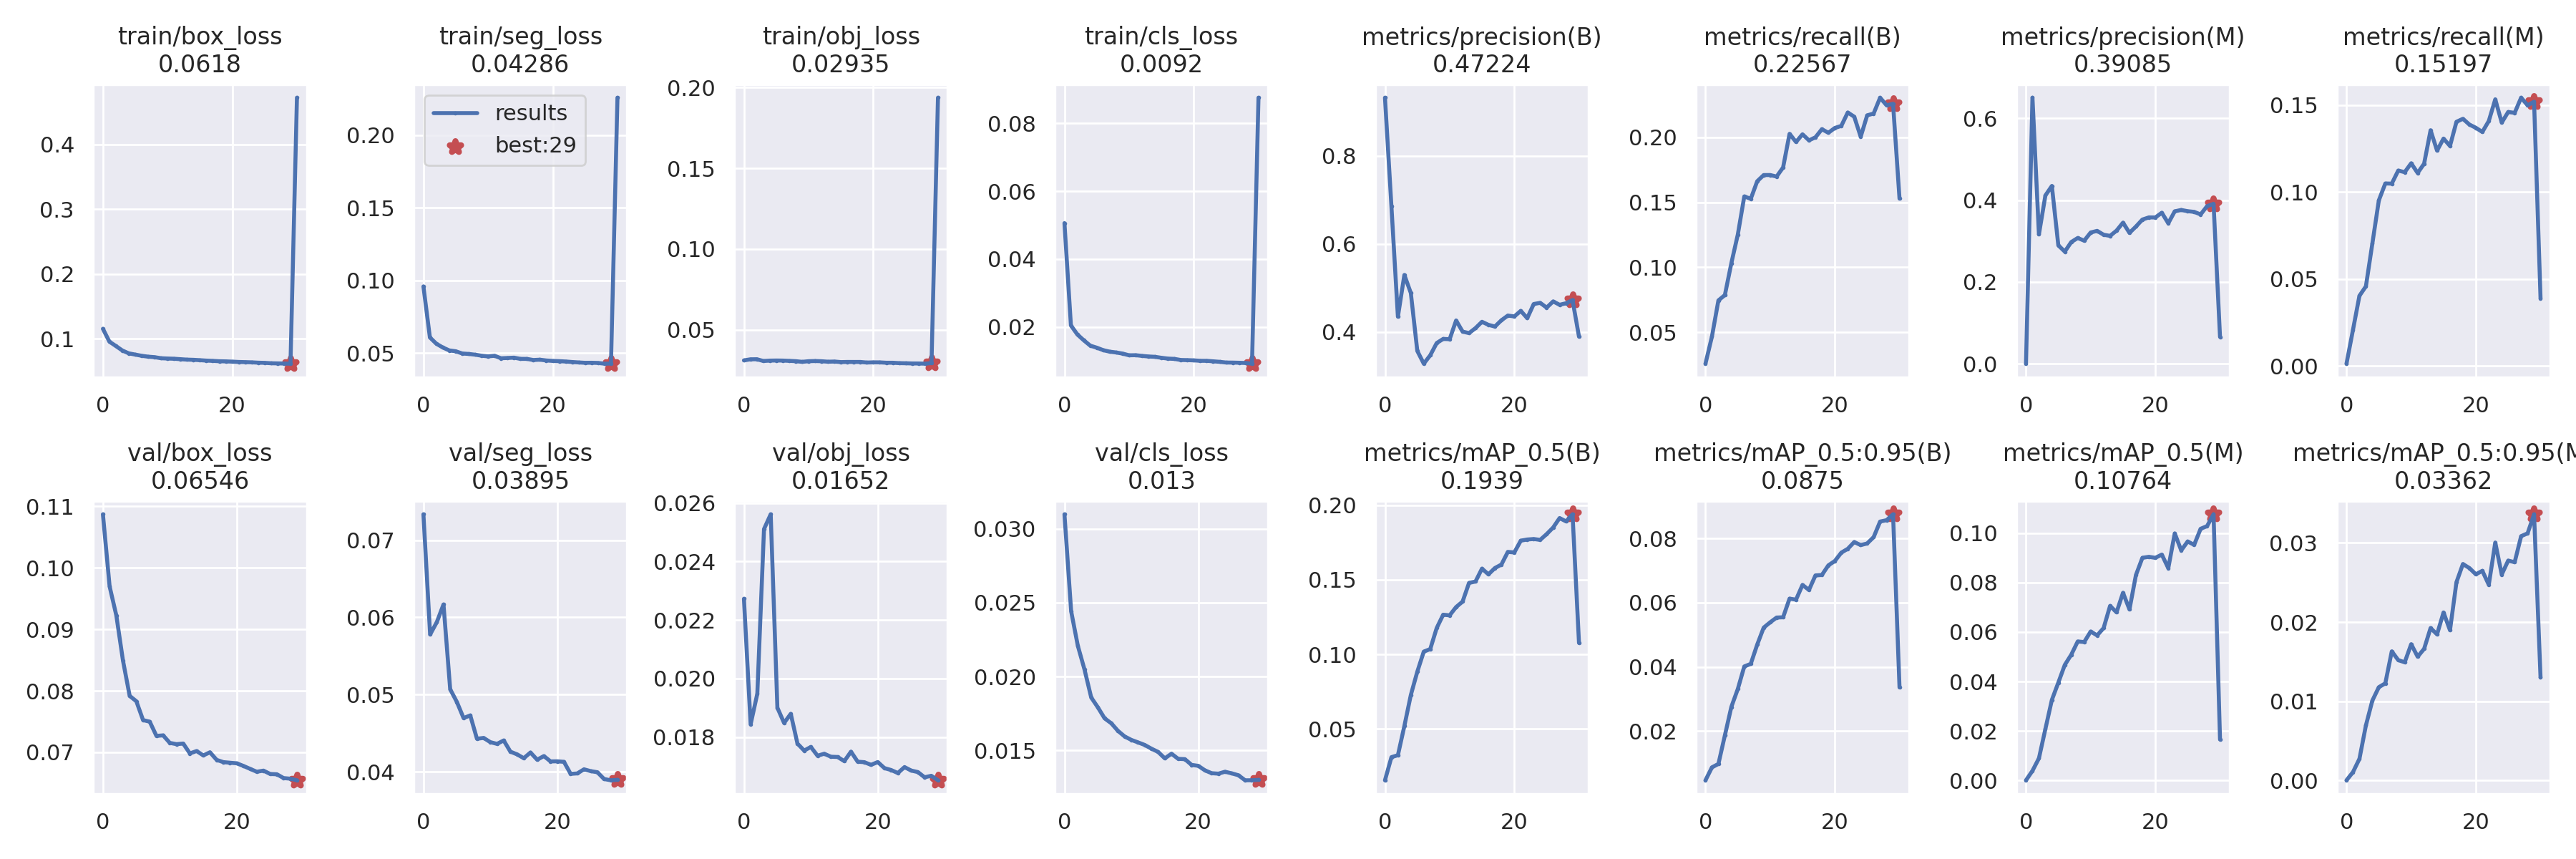

In [8]:
Image(filename=f'{HOME}/yolov5/runs/train-seg/custom-dataset/results.png', width=1200)

Above we see training plots for our custom trained model. This plot along with other detailed results and sample predictions are all automatically generated and stored in the `runs` folder. See `runs/train-seg/exp`.

### Validate Your Custom Model

Repeat step 2 from above to test and validate your custom model.

In [9]:
%cd {HOME}/yolov5
!python segment/val.py \
  --weights {HOME}/yolov5/runs/train-seg/custom-dataset/weights/best.pt \
  --data {dataset.location}/data.yaml \
  --img 320 \
  --name custom-dataset

/content/yolov5
segment/val: data=/content/yolov5/Custom-Workflow-Instance-Segmentation-1/data.yaml, weights=['/content/yolov5/runs/train-seg/custom-dataset/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val-seg, name=custom-dataset, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-398-g5cdad892 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 165 layers, 7425392 parameters, 0 gradients, 25.8 GFLOPs
val: Scanning /content/yolov5/Custom-Workflow-Instance-Segmentation-1/valid/labels.cache... 1700 images, 0 backgrounds, 0 corrupt: 100% 1700/1700 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/yolov5/Custom-Workflow-Instance-Segmentation-1/valid/images/rs00174_jpg.rf.40cf02655e4d307d60ed95afa408dc52.jpg: 3 duplicate labels removed
val: WARNING ⚠️ 

### Infer With Your Custom Model

In [12]:
import os

# Set the correct base path
base_path = "yolov5"  # Adjust this to your actual base path

# Set up the paths for weights and image
weights_path = os.path.join(base_path, "runs/train-seg/custom-dataset/weights/best.pt")
image_path = os.path.join(base_path, "Custom-Workflow-Instance-Segmentation-1/valid/images/rail_1.jpg")

# Command to run the prediction
command = f"""
cd {base_path}
python segment/predict.py \
    --img 320 \
    --weights {weights_path} \
    --source {image_path} \
    --name custom-dataset
"""

# Execute the command
os.system(command)


# import os

# if os.path.exists(os.path.join(dataset.location, "test")):
#     split_path = os.path.join(dataset.location, "test", "images")
# else:
#     split_path = os.path.join(dataset.location, "valid", "images")
# example_image_name = os.listdir(split_path)[3]
# example_image_path = os.path.join(split_path, example_image_name)

# %cd {HOME}/yolov5
# !python segment/predict.py \
#   --img 320 \
#   --weights {HOME}/yolov5/runs/train-seg/custom-dataset/weights/best.pt \
#   --source {example_image_path} \
#   --name custom-dataset
# Image(filename=f"{HOME}/yolov5/runs/predict-seg/custom-dataset5/{example_image_name}", width=600)

256

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The image above shows the resulting prediction overlayed on the input image.

## Deploy Model on Roboflow

Once you have finished training your YOLOv5 model, you’ll have a set of trained weights ready for use. These weights will be in the `/content/yolov5/runs/train/custom-dataset/` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv5 weights.

**Up until this point, you could have used our dataset. If you wish to deploy the model, the dataset needs to be in in your workspace. Go back to the `Preparing a custom dataset` section to learn more.**

To upload model weights, add the following code to the “Inference with Custom Model” section in the aforementioned notebook:

In [ ]:
project.version(dataset.version).deploy(model_type="yolov5-seg", model_path=f"/content/yolov5/runs/train-seg/custom-dataset/")

View the status of your deployment at: https://app.roboflow.com/model-examples/asl-poly-instance-seg-yj9cg/2
Share your model with the world at: https://universe.roboflow.com/model-examples/asl-poly-instance-seg-yj9cg/model/2


In [ ]:
# Run inference on your model on a persistant, auto-scaling, cloud API

# Load model
model = project.version(dataset.version).model
assert model, "Model deployment is still loading"

# Choose a random test image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image).json()
pred

running inference on U21_jpg.rf.e0eab5b5663890305cd1f5c1014cf102.jpg


{'predictions': [{'x': 234.0,
   'y': 230.5,
   'width': 144.0,
   'height': 245.0,
   'confidence': 0.9269440174102783,
   'class': 'B',
   'points': [{'x': 198.9, 'y': 109.2},
    {'x': 197.6, 'y': 110.5},
    {'x': 197.6, 'y': 128.70000000000002},
    {'x': 198.9, 'y': 130.0},
    {'x': 198.9, 'y': 131.3},
    {'x': 201.5, 'y': 133.9},
    {'x': 201.5, 'y': 135.20000000000002},
    {'x': 202.8, 'y': 136.5},
    {'x': 202.8, 'y': 148.20000000000002},
    {'x': 206.70000000000002, 'y': 152.1},
    {'x': 206.70000000000002, 'y': 153.4},
    {'x': 208.0, 'y': 154.70000000000002},
    {'x': 208.0, 'y': 178.1},
    {'x': 209.3, 'y': 179.4},
    {'x': 209.3, 'y': 180.70000000000002},
    {'x': 211.9, 'y': 183.3},
    {'x': 211.9, 'y': 184.6},
    {'x': 213.20000000000002, 'y': 185.9},
    {'x': 213.20000000000002, 'y': 193.70000000000002},
    {'x': 214.5, 'y': 195.0},
    {'x': 214.5, 'y': 196.3},
    {'x': 215.8, 'y': 196.3},
    {'x': 217.1, 'y': 197.6},
    {'x': 217.1, 'y': 198.9},
  

## (OPTIONAL) Improve Our Model with Active Learning

Now that we've trained our model once, we will want to continue to improve its performance. Improvement is largely dependent on improving our dataset.

We can programmatically upload example failure images back to our custom dataset based on conditions (like seeing an underrpresented class or a low confidence score) using the same `pip` package.

In [ ]:
#Prepare Our Example Image Directory
#To run on your own images, replace the directory on the line below with a
#directory you provide (by uploading to the colab environment, for example)
example_image_dir = "../example_images"

#We are going to download example images from the web for the purposes of this
#demo. These images are relevant to the ASL Poly dataset. Skip the rest of this
#cell if you are providing your own example image directory.
os.makedirs(example_image_dir, exist_ok=True)
image_urls = [
    "https://i.imgur.com/rFsDnHC.jpg",
    "https://i.imgur.com/aEcceXm.jpg",
    "https://i.imgur.com/s4N63fx.jpg",
    ]

for i, image_url in enumerate(image_urls):
    response = requests.get(image_url)
    response.raise_for_status()
    with open(os.path.join(example_image_dir,f'example_{i}.jpg'), 'wb') as handler:
        handler.write(response.content)

In [ ]:
#Infer On Directory
!python segment/predict.py --img 320 --weights runs/train-seg/exp/weights/best.pt --source {example_image_dir} --save-txt --save-conf

segment/predict: weights=['runs/train-seg/exp/weights/best.pt'], source=../example_images, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v6.2-149-g77dcf55 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 165 layers, 7465847 parameters, 0 gradients, 25.9 GFLOPs
image 1/3 /content/example_images/example_0.jpg: 320x320 1 L, 1 Y, 8.2ms
image 2/3 /content/example_images/example_1.jpg: 320x320 1 G, 1 I, 8.7ms
image 3/3 /content/example_images/example_2.jpg: 320x320 1 H, 6.9ms
Speed: 0.3ms pre-process, 8.0ms inference, 1.0ms NMS per image at shape (1, 3, 320, 32

In [ ]:
#Read Results Files and Conditionally Upload

#If my model has a confidence of less than 80% for a prediction, let's help it
#out by uploading this image back to our dataset. Then we can add a ground truth
#label to it so that it will be included in our next training run and future
#prediction results will improve.
MIN_CONF_THRESHOLD = 0.8

for i,txt_file in enumerate(os.listdir("runs/predict-seg/exp3/labels")):
  with open(os.path.join("runs/predict-seg/exp3/labels",txt_file), 'r') as fid:
    for line in fid:
      label, x1, y1, x2, y2, conf = line.split(" ")
      conf = float(conf)
      if conf < MIN_CONF_THRESHOLD:
        print(f"Image has a low confidence prediction, uploading to project: example_{i}.jpg")
        #Upload via Roboflow pip package
        project.upload(os.path.join(example_image_dir,f'example_{i}.jpg'))
        break

Image has a low confidence prediction, uploading to project: example_0.jpg
Image has a low confidence prediction, uploading to project: example_1.jpg
Image has a low confidence prediction, uploading to project: example_2.jpg
